In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

# Import the Datasets

In [2]:
# Data Gathered By Me Via the MyAnimeList API and Jikan REST API
anime_df = pd.read_csv('./data/anime.csv')
user_ratings_df = pd.read_csv('./data/user_ratings.csv')

In [3]:
# Data From https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020
kaggle_user_ratings_df = pd.read_csv('./data/kaggle_anime_data/rating_complete.csv')

In [4]:
anime_df.head()

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,1.0,3,3240265,2056814,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
1,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,2.0,13,2489957,1361494,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
2,28977,Gintama°,2015-04-08,2016-03-30,"Gintoki, Shinpachi, and Kagura return as the f...",9.06,3.0,336,610158,243298,tv,finished_airing,"Action,Comedy,Gag Humor,Historical,Parody,Samu...",51,spring,wednesday,18:00,manga,pg_13,Bandai Namco Pictures
3,41467,Bleach: Sennen Kessen-hen,2022-10-11,2022-12-27,Substitute Soul Reaper Ichigo Kurosaki spends ...,9.05,4.0,432,489199,245969,tv,finished_airing,"Action,Adventure,Fantasy,Shounen",13,fall,tuesday,00:00,manga,r,Pierrot
4,39486,Gintama: The Final,2021-01-08,2021-01-08,Two years have passed following the Tendoshuu'...,9.05,5.0,1550,140032,67119,movie,finished_airing,"Action,Comedy,Drama,Gag Humor,Historical,Parod...",1,winter,NaN,NaN,manga,pg_13,Bandai Namco Pictures


In [5]:
user_ratings_df.head()

,user_id,anime_id,score,status,num_episodes_watched,updated_at,start_date,finish_date
0,0,41457,7,completed,11,2023-02-16T10:18:23+00:00,NaN,2023-01-01
1,0,48569,7,watching,7,2023-03-09T11:11:20+00:00,2023-01-01,NaN
2,0,32998,9,completed,12,2023-04-15T14:29:11+00:00,NaN,2023-01-01
3,0,25013,0,plan_to_watch,0,2023-04-15T14:44:38+00:00,NaN,NaN
4,0,36649,7,completed,24,2023-04-15T14:29:23+00:00,NaN,2023-01-01


In [6]:
kaggle_user_ratings_df.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


# Extract Data From Kaggle User Ratings Dataset
This dataset is being used because my dataset is very low on data of new users, so I will suppliment my existing data with some data from this dataset on new users.

In [7]:
user_id_counts = kaggle_user_ratings_df['user_id'].value_counts()
user_id_counts.head()

user_id
189037    15455
162615    14864
68042     13462
283786    12778
259790     9996
Name: count, dtype: int64

In [8]:
new_user_max_rating_count = 30 # The maximum number of ratings for a user to be consider 'new'

users_to_extract = [] # The ids of the users that should be extracted from the dataset

for id, user_rating_count in user_id_counts.items():
  if user_rating_count <= new_user_max_rating_count:
    users_to_extract.append(id)

In [9]:
len(users_to_extract)

61123

This is way too many users to add to extract, I'll pick 1000 random users to sample.

In [10]:
extracted_users_sample = pd.Series(users_to_extract).sample(1000)
extracted_kaggle_user_ratings_df = kaggle_user_ratings_df.loc[kaggle_user_ratings_df.user_id.isin(extracted_users_sample)]

In [11]:
extracted_kaggle_user_ratings_df.head()

,user_id,anime_id,rating
4143,31,4224,10
79673,540,4224,10
79674,540,9989,9
79675,540,11433,8
79676,540,11111,9


## Ensure all users in the extracted dataframe are new

In [12]:
num_old_users = 0

for user_id, count in extracted_kaggle_user_ratings_df['user_id'].value_counts().items():
  if count > new_user_max_rating_count:
    num_old_users += 1

print(f"There are {num_old_users} users that aren't new.")

There are 0 users that aren't new.


## Replace the Existing Extracted User ID with an ID Unique to the User Ratings Dataset

In [13]:
new_user_id = max(user_ratings_df['user_id'].unique())+1

for user_id in extracted_kaggle_user_ratings_df['user_id'].unique():
  extracted_kaggle_user_ratings_df.replace(user_id, new_user_id)
  new_user_id += 1

## Add the Extracted Dataset to the Existing Dataset

In [16]:
extracted_kaggle_user_ratings_df.rename(columns={'rating': 'score'})
combined_user_ratings_df = pd.concat([user_ratings_df, extracted_kaggle_user_ratings_df])

In [17]:
num_extracted = len(extracted_kaggle_user_ratings_df['user_id'].unique())
num_combined = len(combined_user_ratings_df['user_id'].unique())

print(f"Num Extracted Users: {num_extracted}, Num Combined Users: {num_combined}")

Num Extracted Users: 1000, Num Combined Users: 9712


# Explore the Combined User Ratings Dataset

## Aggregate the Combined User Ratings Dataset for Exploration

In [18]:
aggregated_user_ratings_df = combined_user_ratings_df.groupby('user_id').agg({'score': ['min', 'mean', 'max'], 'anime_id': 'count', 'num_episodes_watched': 'mean'})
aggregated_user_ratings_df.head()

score                 anime_id num_episodes_watched
          min      mean   max    count                 mean
user_id                                                    
0         0.0  7.236559  10.0       93            27.301075
1         0.0  6.024055  10.0      291            14.134021
2         0.0  6.022388  10.0      134            11.552239
3         0.0  5.951220  10.0       82            32.024390
4         0.0  5.175115  10.0      434            17.585253

### Plot the  Number of Users in Each Range of the Number of Anime They Rated
This is a plot of the different ranges of how many users have rated a certain number of anime i.e. how many users have rated between 0 and 30 anime.

In [19]:
def get_num_between_ratings(min_rating_num, max_rating_num):
  users_range_df = aggregated_user_ratings_df.loc[(aggregated_user_ratings_df['anime_id']['count'] >= min_rating_num) & (aggregated_user_ratings_df['anime_id']['count'] <= max_rating_num)]
  return len(users_range_df['anime_id']['count'])

user_rating_num_ranges = {
    "0 - 30": get_num_between_ratings(0, 30),
    "31 - 100": get_num_between_ratings(31, 100),
    "101 - 250": get_num_between_ratings(101, 250),
    "251 - 500": get_num_between_ratings(251, 500),
    "501 - 1000": get_num_between_ratings(501, 1000),
}

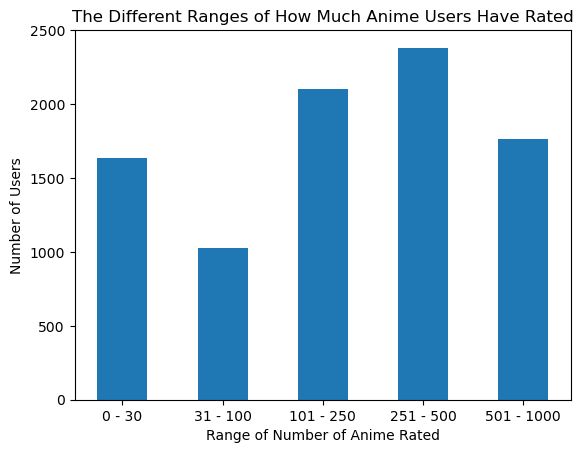

In [21]:
num_users_rated_in_range_labels = list(user_rating_num_ranges.keys())
num_users_rated_in_range_values = list(user_rating_num_ranges.values())

plt.bar(num_users_rated_in_range_labels, num_users_rated_in_range_values, width=0.5)
plt.title('The Different Ranges of How Much Anime Users Have Rated')
plt.xlabel('Range of Number of Anime Rated')
plt.ylabel('Number of Users')
plt.show()

As you can see, there is now enough *new users* compared to *other users*. This will mean the model(s) should have enough data on new users for the project to work.